# <font color="gold"><b>RNN</b></font>
### <font color="green"><b>Steps performed:</b></font>
<div style="color:cyan;font-weight:bold;">
1) Load dataset<br>
2) visualize the feature column<br>
3) Plot seasonal decompose<br>
4) Split data into Train-Test<br>
5) Scale the data<br>
6) Feeding batches of data to RNN<br>
7) Building LSTM Model <br>
8) Visualizing the fitted model<br>
9) Evaluation batch on test data<br>
10) Forecast using RNN Model<br>
11) Inverse Transformations and Comparison<br>
12) Saving and loading the model<br>
</div>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../Data/Alcohol_Sales.csv", index_col="DATE", parse_dates=True)
df.index.freq="MS"
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


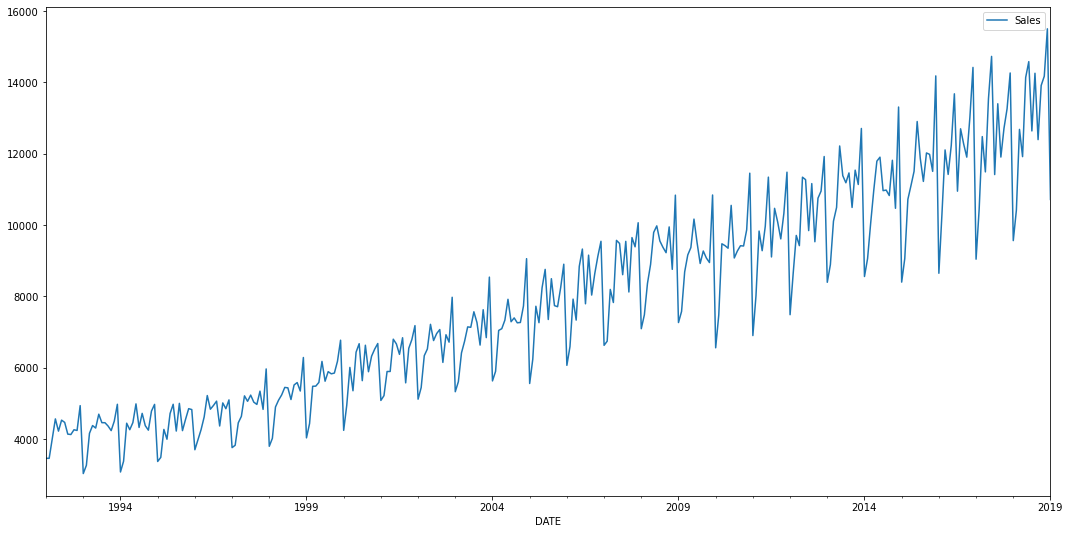

In [3]:
df.plot(figsize=(18,9));

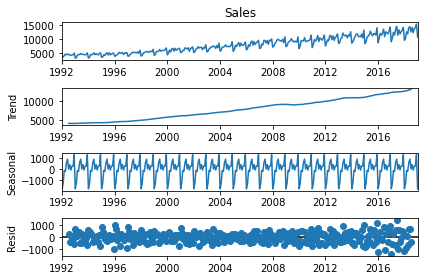

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = seasonal_decompose(df['Sales'])
decompositions.plot();

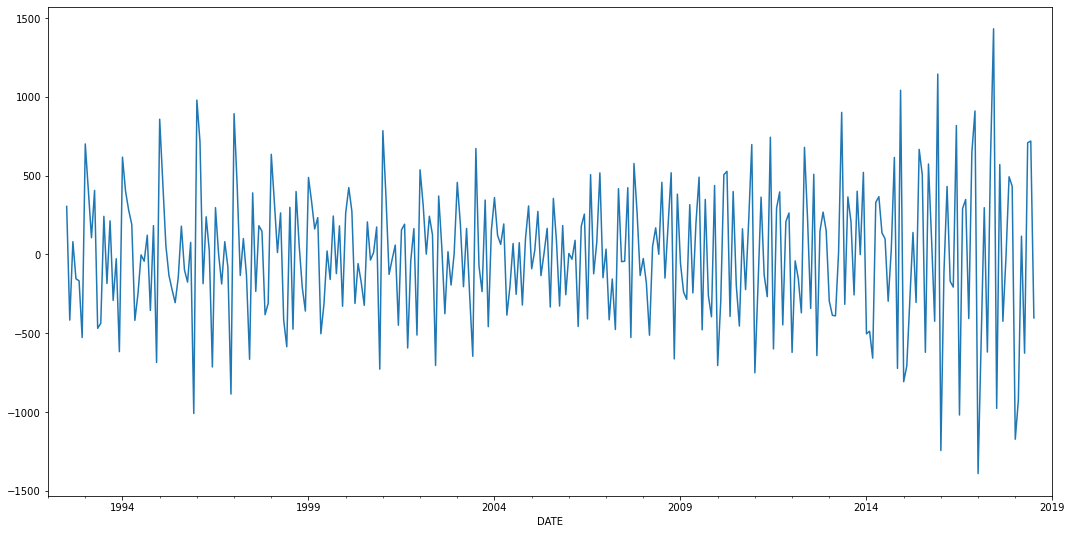

In [5]:
decompositions.resid.plot(figsize=(18,9));

# <font color="gold"><ins><b>Train-Test Split and Scale Data</b></ins></font>

In [6]:
train, test = df.iloc[:313], df.iloc[313:]

from sklearn.preprocessing import MinMaxScaler
import warnings

scaler = MinMaxScaler()

warnings.filterwarnings("ignore")
# Fit only to train dataset, as Test Dataset's scale is unknown
scaler.fit(train)

scaled_train_data = scaler.transform(train)
scaled_test_data = scaler.transform(test)

# <font color="gold"><b>Step6: Feeding batches of data to RNN via <ins>Time Series Generator</ins></b></font>

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.


In [7]:
# For feeding batches of data to RNN
from keras.preprocessing.sequence import TimeseriesGenerator

# usually equal to the seasonal period cycle, i.e. 7 for day level data, 12 for month level data, etc
n_input = 12
n_features = 1

# since source of data and traget are same, pass scaled train dataset twice
train_generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


In [8]:
print("Len of train_dataset = len of generator + len of n_input")
print(f" {len(scaled_train_data)} = {len(train_generator)} + {n_input}")

Len of train_dataset = len of generator + len of n_input
 313 = 301 + 12


What _TimeseriesGenerator_ does for us is tranform the sequence <br>
> [t1,t2,t3,t4,t5,t6] into <br>
> [t1,t2,t3,t4,t5] -> [t6] <br>
i.e. it takes a sequence of data, transforms it to the above format, i.e. the input format of RNN <br>
and LHS is features, RHS is label for the RNN for each batch <br>

In [9]:
X, y = train_generator[0]
print("#Length of training data:\n",X); print("\n#Prdicting:",y); 

#Length of training data:
 [[[0.03658432]
  [0.03649885]
  [0.08299855]
  [0.13103684]
  [0.1017181 ]
  [0.12804513]
  [0.12266006]
  [0.09453799]
  [0.09359774]
  [0.10496624]
  [0.10334217]
  [0.16283443]]]

#Prdicting: [[0.]]


# <font color="gold"><ins><b>Step7: Building the LSTM Model</ins></b></font>

In [44]:
from keras.models import Sequential
from keras.layers import Dense, LSTM 

model = Sequential()
model.add((LSTM(150, activation='relu', input_shape=(n_input, n_features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit_generator(train_generator, epochs=40)

Epoch 1/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0155
Epoch 2/40
301/301 [==============================] - 1s 4ms/step - loss: 0.0096
Epoch 3/40
301/301 [==============================] - 1s 4ms/step - loss: 0.0090
Epoch 4/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0074
Epoch 5/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0050
Epoch 6/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0041
Epoch 7/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0035
Epoch 8/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0029
Epoch 9/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 10/40
301/301 [==============================] - 1s 5ms/step - loss: 0.0023
Epoch 11/40
301/301 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 12/40
301/301 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 13/40
301/301 [====

In [46]:
model.history.history.keys()

dict_keys(['loss'])

# <font color="gold"><ins><b>Step8: Visualizing the fitted model</ins></b></font>

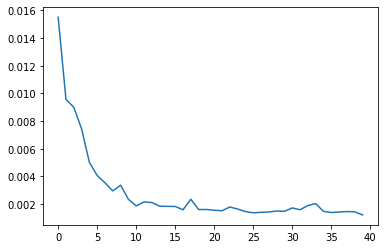

In [47]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

# <font color="gold"><ins><b>Step9: Evaluation Batch on Test Data</b></ins></font>
Model is working on the monthly data for a sequence of ___(12 hsitory points)___ -> ___(13th point)___ <br>
So we have to have last ___(12 point of train data)___ -> to predict ___(13th step)___

In [48]:
first_eval_batch = scaled_train_data[-12:]

In [49]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
first_eval_batch.shape

(1, 12, 1)

In [50]:
model.predict(first_eval_batch)

array([[0.71944517]], dtype=float32)

In [51]:
scaled_test_data[0]

array([0.63116506])

# <font color="gold"><ins><b>Step10: Forecast using RNN Model</ins></b></font>

In [52]:
# Holds the predections
test_predictions = []

# last n_input points from the training dataset
first_eval_batch = scaled_train_data[-n_input:]
# Reshaping it to the format RNN expects
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# How far to predict?
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [53]:
test_predictions

[array([0.71944517], dtype=float32),
 array([0.8246689], dtype=float32),
 array([0.79565245], dtype=float32),
 array([0.9558402], dtype=float32),
 array([1.0231148], dtype=float32),
 array([0.7802109], dtype=float32),
 array([0.92875373], dtype=float32),
 array([0.8004954], dtype=float32),
 array([0.8882527], dtype=float32),
 array([0.91963303], dtype=float32),
 array([0.9927413], dtype=float32),
 array([0.61230874], dtype=float32)]

In [54]:
scaled_test_data

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

# <font color="gold"><ins><b>Step11: Inverse Transformations and Comparison</b></ins></font>

In [55]:
true_predictions = scaler.inverse_transform(test_predictions)

In [56]:
test.head()

,Sales,Predictions
DATE,,
2018-02-01,10415,10956.217006
2018-03-01,12683,12371.926309
2018-04-01,11919,11866.155561
2018-05-01,14138,13769.863849
2018-06-01,14583,14553.368085


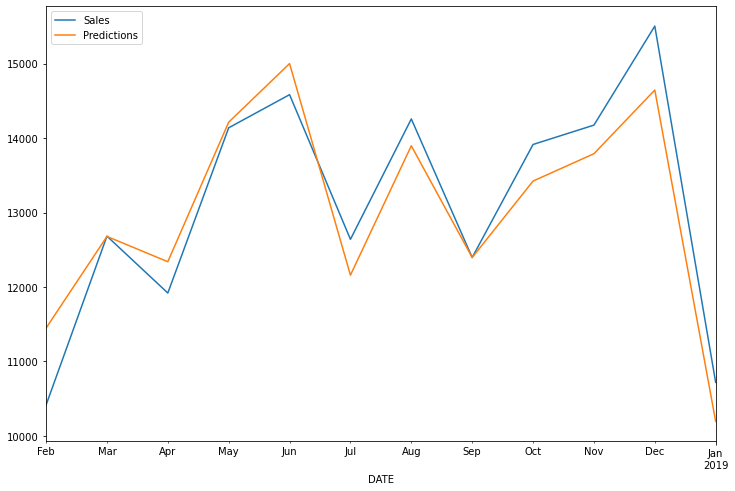

In [57]:
test['Predictions'] = true_predictions
test.plot(figsize=(12,8));

# <font color="gold"><ins><b>Step12: Saving and loading the model</b></ins></font>

In [58]:
model.save("./saved_models/LSTM_Alcohol_Sales")

INFO:tensorflow:Assets written to: ./saved_models/LSTM_Alcohol_Sales\assets


In [59]:
from keras.models import load_model
new_model = load_model("./saved_models/LSTM_Alcohol_Sales")
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
